##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 TensorFlow Lite 进行艺术风格迁移

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/lite/examples/style_transfer/overview"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/models/style_transfer/overview.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 运行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lite/models/style_transfer/overview.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lite/models/style_transfer/overview.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
  <td>     <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型 </a> </td>
</table>

最近，深度学习领域最令人激动的发展之一是[艺术风格迁移](https://arxiv.org/abs/1508.06576)（或者说是创建新图像的能力），这种技术称为[混仿](https://en.wikipedia.org/wiki/Pastiche)，它基于两张输入图像：一张代表艺术风格，另一张代表内容。

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/formula.png)

利用这种技术，我们可以使用一系列风格生成漂亮的新作品。

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

如果您是 TensorFlow Lite 新用户，并且使用的是 Android 平台，我们建议您研究以下可以帮助您入门的示例应用。

<a class="button button-primary" href="https://github.com/tensorflow/examples/tree/master/lite/examples/style_transfer/android">Android 示例</a> <a class="button button-primary" href="https://github.com/tensorflow/examples/tree/master/lite/examples/style_transfer/ios">iOS 示例</a>

如果您使用的不是 Android 或 iOS 平台，或者您已经熟悉 <a href="https://tensorflow.google.cn/api_docs/python/tf/lite">TensorFlow Lite API</a>，则可以按照本教程学习如何使用预训练的 TensorFlow Lite 模型为任何一对内容与风格图像应用风格迁移。利用该模型，您可以将风格迁移添加到自己的移动应用。

该模型在 [GitHub](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization#train-a-model-on-a-large-dataset-with-data-augmentation-to-run-on-mobile) 上开源。您可以使用不同的参数重新训练它（例如，提高内容层权重，使输出图像看起来更像内容图像）。

## 了解模型架构

![Model Architecture](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/architecture.png)

该艺术风格迁移模型包括两个子模型：

1. **风格预测模型**：一个基于 MobilenetV2 的神经网络，它将输入风格图像转换为 100 维风格瓶颈向量。
2. **风格迁移模型**：将风格瓶颈向量应用到内容图像并创建风格化图像的神经网络。

如果您的应用只需要支持一组固定的风格图像，则可以提前计算其风格瓶颈向量，并从应用的二进制文件中排除风格预测模型。

## 设置

导入依赖项。

In [2]:
import tensorflow as tf
print(tf.__version__)

2022-08-31 02:30:44.049782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2022-08-31 02:30:44.768989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2022-08-31 02:30:44.769254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2022-08-31 02:30:44.769267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.10.0-rc3


In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

下载内容和风格图像以及预训练的 TensorFlow Lite 模型。

In [4]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

  8192/458481 [..............................] - ETA: 0s

458481/458481 [==============================] - 0s 0us/step


  8192/108525 [=>............................] - ETA: 0s

108525/108525 [==============================] - 0s 0us/step


   8192/2828838 [..............................] - ETA: 0s

2828838/2828838 [==============================] - 0s 0us/step


  8192/284398 [..............................] - ETA: 0s

284398/284398 [==============================] - 0s 0us/step


## 预处理输入

- 内容图像和风格图像必须是 RGB 格式，且像素值为 [0..1] 范围内的 float32 数字。
- 风格图像大小必须为 (1, 256, 256, 3)。我们从中间裁剪该图像并调整其大小。
- 内容图像必须为 (1, 384, 384, 3)。我们从中间裁剪该图像并调整其大小。

In [5]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


## 可视化输入

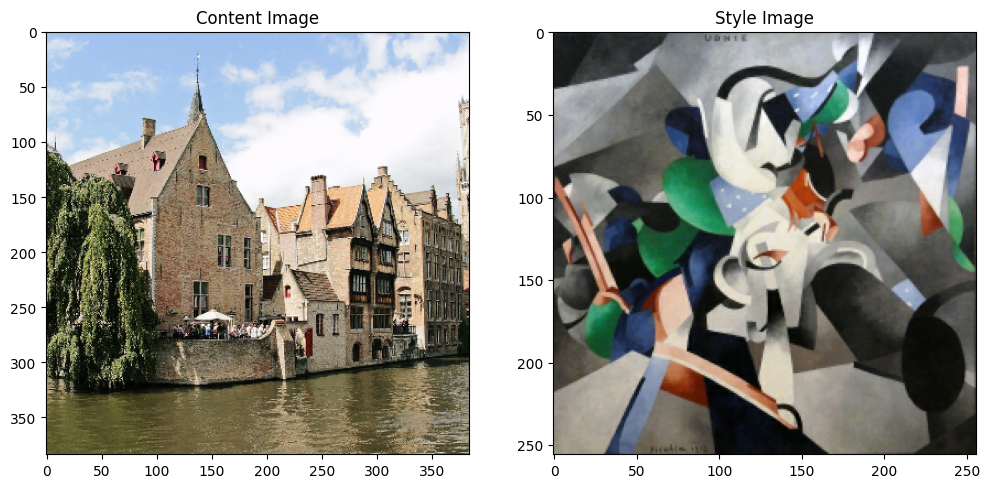

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

## 使用 TensorFlow Lite 运行风格迁移

### 风格预测

In [7]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### 风格迁移

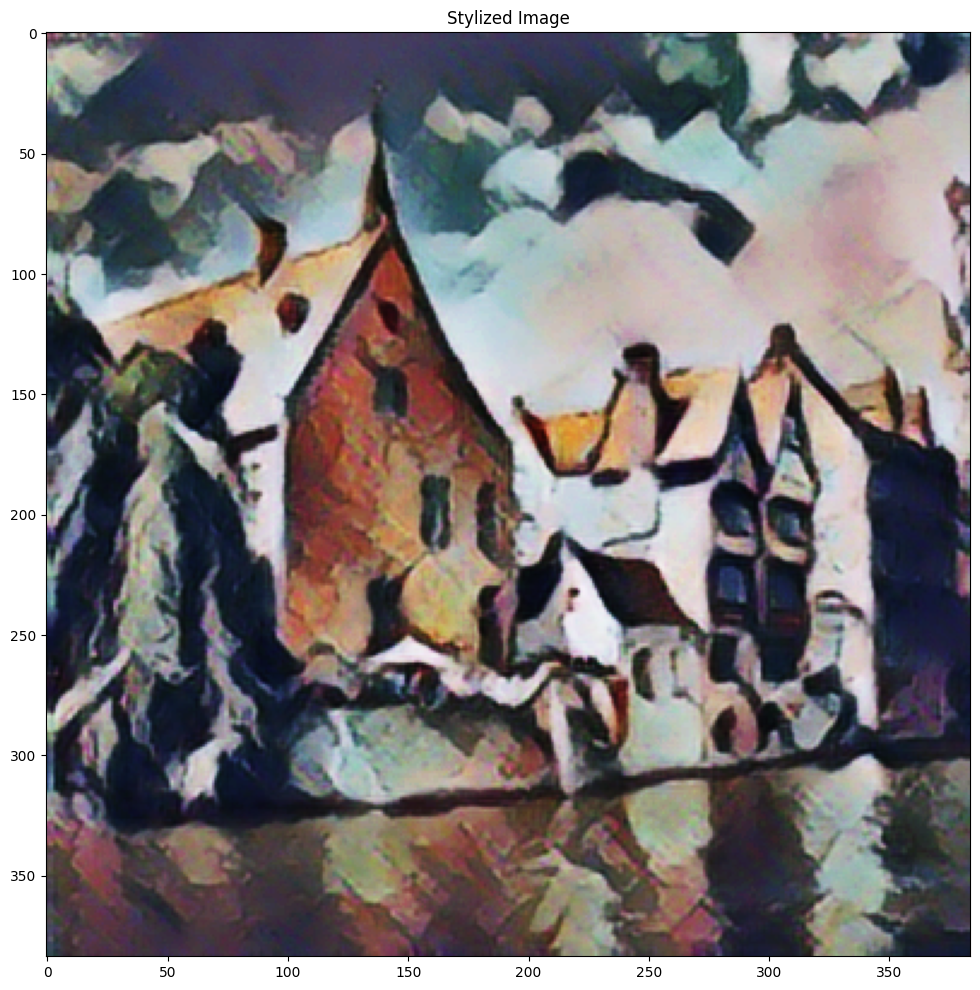

In [8]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

### 风格混合

我们可以将内容图像的风格混合到风格化输出中，使输出看起来更像内容图像。

In [9]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

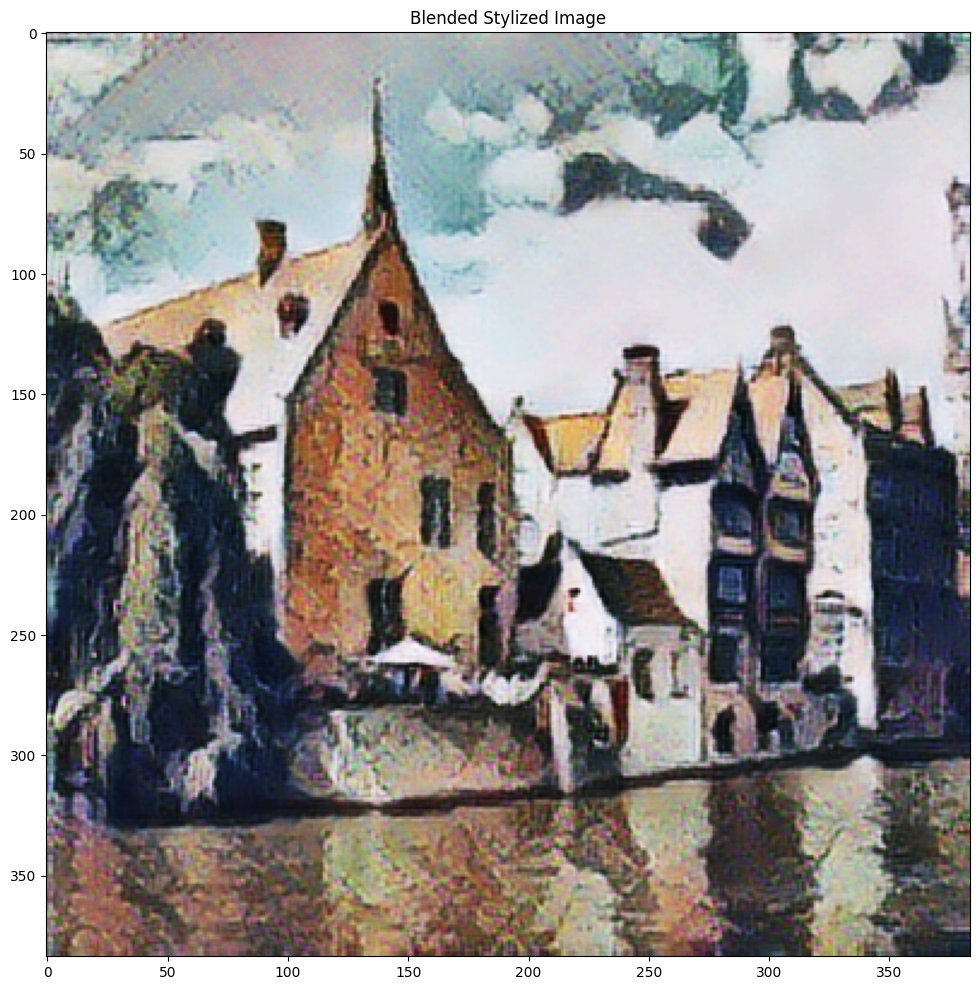

In [10]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

## 性能基准

性能基准数值通过使用[此处所述](https://tensorflow.google.cn/lite/performance/benchmarks)的工具生成。

<table>
<thead>
<tr>
<th>模型名称</th> <th>模型大小</th>  <th>设备</th> <th>NNAPI</th> <th>CPU</th> <th>GPU</th>
</tr> </thead>
<tr> <td rowspan="3"> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite">风格预测模型 (int8)</a> </td>
<td rowspan="3">2.8 Mb</td>
<td>Pixel 3 (Android 10)</td> <td>142ms</td>
<td>14ms*</td>
<td></td>
</tr>
<tr>
<td>Pixel 4 (Android 10)</td> <td>5.2ms</td>
<td>6.7ms*</td>
<td></td>
</tr>
<tr>
<td>iPhone XS (iOS 12.4.1)</td> <td></td>
<td>10.7ms**</td>
<td></td>
</tr>
<tr> <td rowspan="3"> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite">风格转换模型 (int8)</a> </td>
<td rowspan="3">0.2 Mb</td>
<td>Pixel 3 (Android 10)</td> <td></td>
<td>540ms*</td>
<td></td>
</tr>
<tr>
<td>Pixel 4 (Android 10)</td> <td></td>
<td>405ms*</td>
<td></td>
</tr>
<tr>
<td>iPhone XS (iOS 12.4.1)</td> <td></td>
<td>251ms**</td>
<td></td>
</tr>
<tr> <td rowspan="2"> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/fp16/prediction/1?lite-format=tflite">风格预测模型 (float16)</a> </td>
<td rowspan="2">4.7 Mb</td>
<td>Pixel 3 (Android 10)</td> <td>86ms</td>
<td>28ms*</td>
<td>9.1ms</td>
</tr>
<tr>
<td>Pixel 4 (Android 10)</td>
<td>32ms</td>
<td>12ms*</td>
<td>10ms</td>
</tr>
<tr> <td rowspan="2"> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/fp16/transfer/1?lite-format=tflite">风格转换模型 (float16)</a> </td>
<td rowspan="2">0.4 Mb</td>
<td>Pixel 3 (Android 10)</td> <td>1095ms</td>
<td>545ms*</td>
<td>42ms</td>
</tr>
<tr>
<td>Pixel 4 (Android 10)</td>
<td>603ms</td>
<td>377ms*</td>
<td>42ms</td>
</tr>
</table>

*** 使用 4 个线程。<br>* *** 为了获得最佳性能结果，在 iPhone 上使用 2 个线程。**
*** 为了获得最佳性能结果，在 iPhone 上使用 2 个线程。*
